In [ ]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

Import the relevant datasets h1,h2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
df_1 = pd.read_csv("/content/drive/My Drive/H1.csv")

In [ ]:
df_2= pd.read_csv("/content/drive/My Drive/H2.csv")

In [ ]:
df_combined = pd.concat([df_1,df_2])

In [ ]:
df_combined.head()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,7/1/2015
1,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,7/1/2015
2,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NULL,NULL,0,Transient,75.0,0,0,Check-Out,7/2/2015
3,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304,NULL,0,Transient,75.0,0,0,Check-Out,7/2/2015
4,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,NULL,0,Transient,98.0,0,1,Check-Out,7/3/2015


In [ ]:
#check NULL values

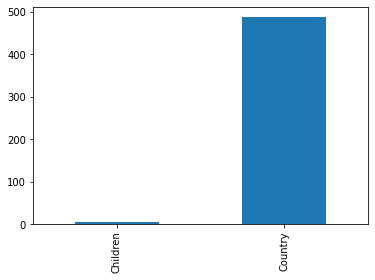

In [ ]:
missing = df_combined.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

500 missing values is barely significant
Hence drop those values as illustrated in cell below



In [ ]:
df_combined=df_combined[df_combined['Country'].notna() & df_combined['Children'].notna()]

In [ ]:
df_combined.drop_duplicates(keep="first",inplace=True)

Get the catergorical and numerical features and split them

In [ ]:
quantitative = [f for f in df_combined.columns if df_combined.dtypes[f] != 'object']
qualitative = [f for f in df_combined.columns if df_combined.dtypes[f] == 'object']


# Categorical Data##

Convert categorical attributes to type category 
and Missing to type missing

In [ ]:
for c in qualitative:
    df_combined[c] =df_combined[c].astype('category')
    if df_combined[c].isnull().any():
        df_combined[c] = df_combined[c].cat.add_categories(['MISSING'])
        df_combined[c] = df_combined[c].fillna('MISSING')

In [ ]:
f = pd.melt(df_combined, id_vars=['IsCanceled'], value_vars=qualitative)

In [ ]:
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


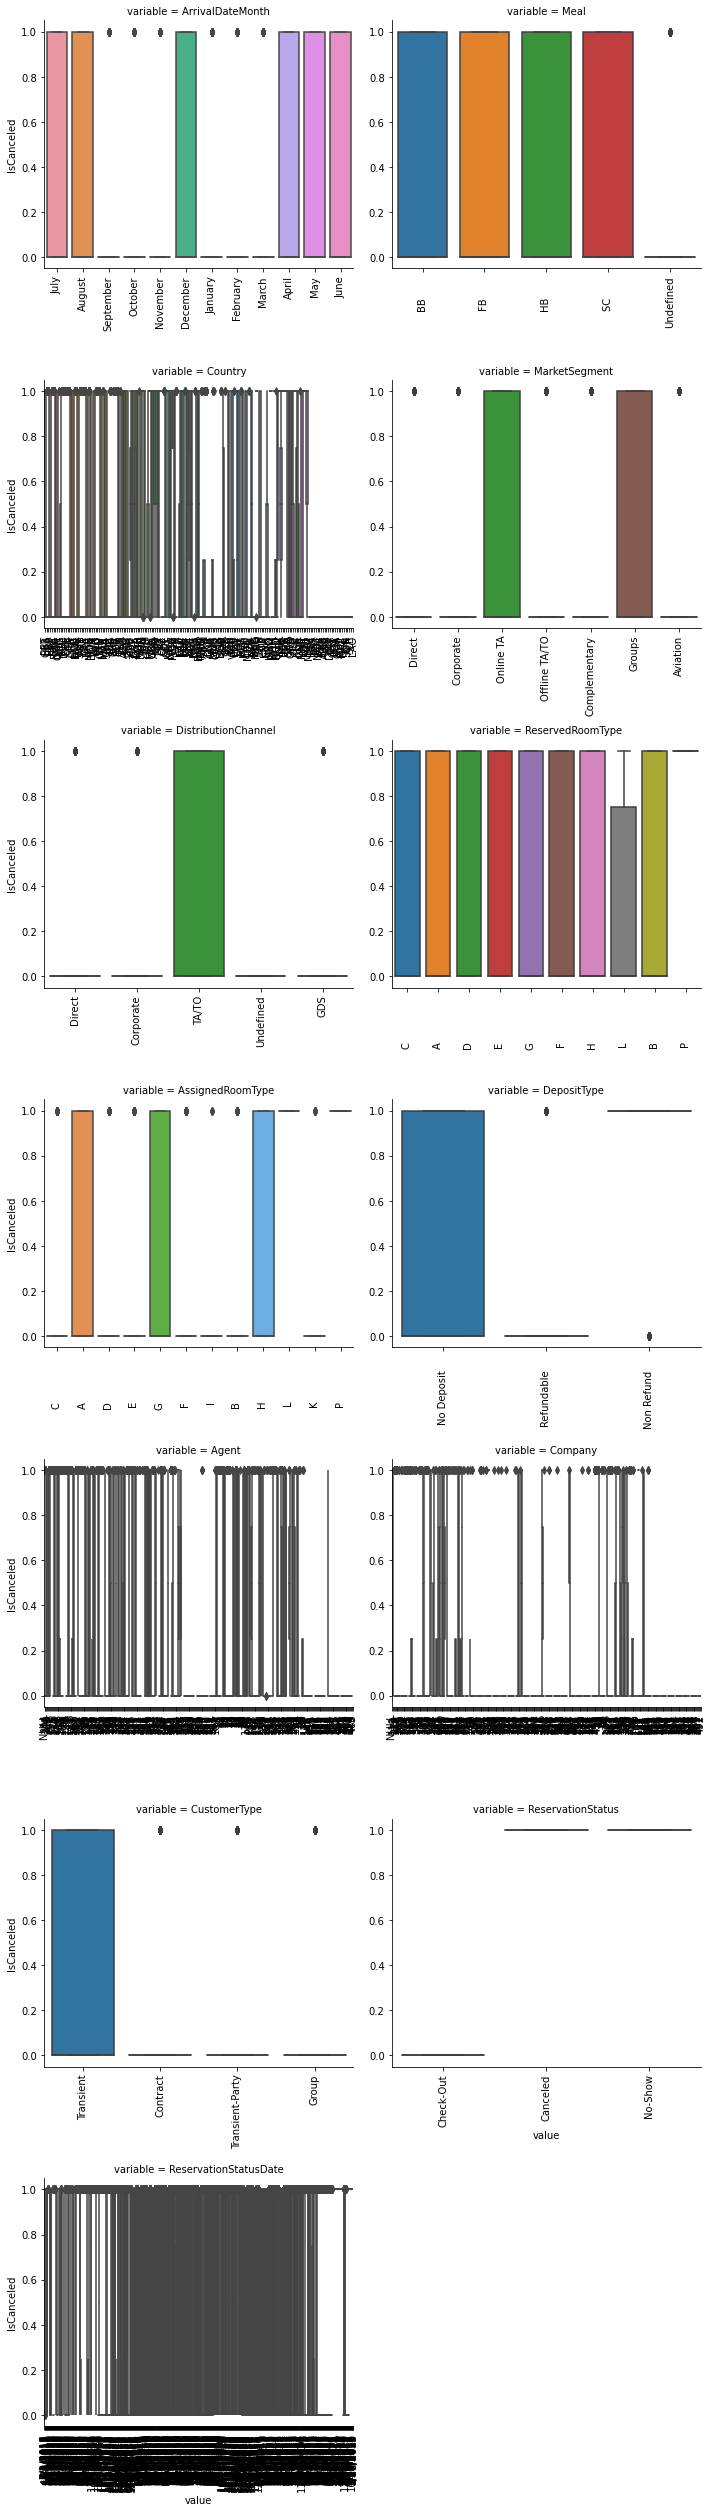

In [ ]:
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot, "value", "IsCanceled")

In [ ]:
# Use Anova to measure correlation with 'IsCancelled'
#@return anova values disparity 

def anova(frame):
    anv = pd.DataFrame()
    anv['feature'] = qualitative
    pvals = []
    for c in qualitative:
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c] == cls]['IsCanceled'].values
            samples.append(s)
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')


In [ ]:
anova_df = anova(df_combined)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in true_divide
  """Entry point for launching an IPython kernel.


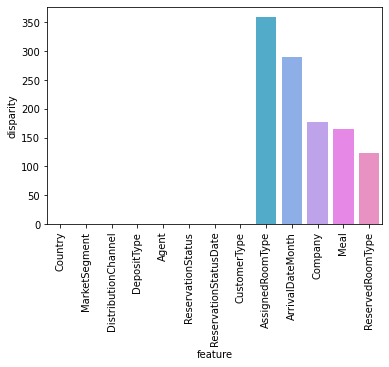

In [ ]:
anova_df['disparity'] = np.log(1./anova_df['pval'].values)
sns.barplot(data=anova_df, x='feature', y='disparity')
x=plt.xticks(rotation=90)

From above it seems that there is a significant disparity between the features above and 'IsCanceled'

good info obtained  

Check distribution of IsCancelled

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


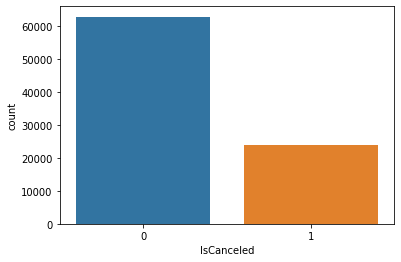

In [ ]:
sns.countplot(df_combined['IsCanceled'])

# Correlation#

In [ ]:
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['IsCanceled'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    return spr
def get_least_Corr(x):
  # Uses the 0.1 threshold: Any feature that doesn't meet that correlation value is to be dropped 
    if(abs(x['spearman']) < 0.1):
        return x['feature']
def encode(frame, feature):
  # ENCODE THE Categorical variables to codes 
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'IsCanceled']].groupby(feature).mean()["IsCanceled"]
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    
    ordering = ordering['ordering'].to_dict()
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o

In [ ]:
def encode(frame, feature):
  # ENCODE THE Categorical variables to codes 
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'IsCanceled']].groupby(feature).mean()["IsCanceled"]
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    
    ordering = ordering['ordering'].to_dict()
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o

In [ ]:
qual_encoded = []
for q in qualitative:  
    encode(df_combined, q)
    qual_encoded.append(q+'_E')

['ArrivalDateMonth_E', 'Meal_E', 'Country_E', 'MarketSegment_E', 'DistributionChannel_E', 'ReservedRoomType_E', 'AssignedRoomType_E', 'DepositType_E', 'Agent_E', 'Company_E', 'CustomerType_E', 'ReservationStatus_E', 'ReservationStatusDate_E']


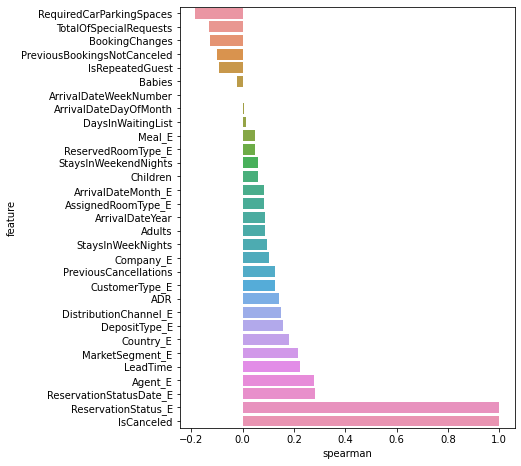

In [ ]:
features = quantitative + qual_encoded

spr = spearman(df_combined
         , features)
plt.figure(figsize=(6, 0.25*len(features)))
sns.barplot(data=spr, y='feature', x='spearman', orient='h')

In [ ]:
spr.to_csv("correlationToIscancelled.csv")

In [ ]:
leastCorr = spr.apply(lambda x :get_least_Corr(x) ,axis=1)
leastCorrFeatures = [i for i in list(leastCorr.values) if i != None]

Due to high correlation between ReservationStatus_E	 and IsCanceled (a correlation value of 0.997887) its best to remove the feature.line below does that



In [ ]:
leastCorrFeatures.append("ReservationStatus_E")


In [ ]:
def pairplot(x, y, **kwargs):
    ax = plt.gca()
    ts = pd.DataFrame({'time': x, 'val': y})
    ts = ts.groupby('time').mean()
    ts.plot(ax=ax)
    plt.xticks(rotation=90)

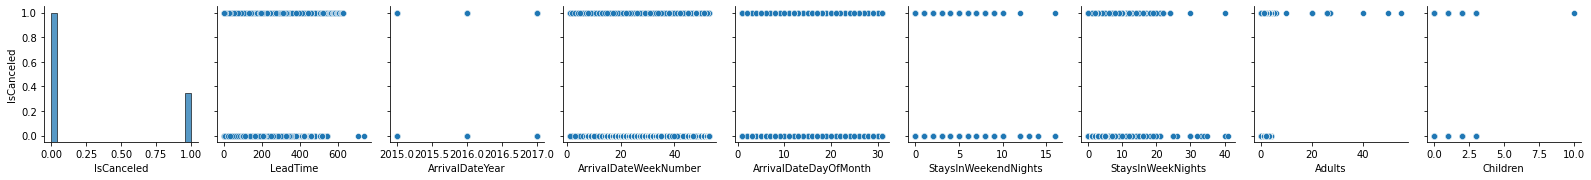

In [ ]:
sns.pairplot(df_combined[quantitative+qual_encoded],y_vars=["IsCanceled"],x_vars=quantitative[0:9])

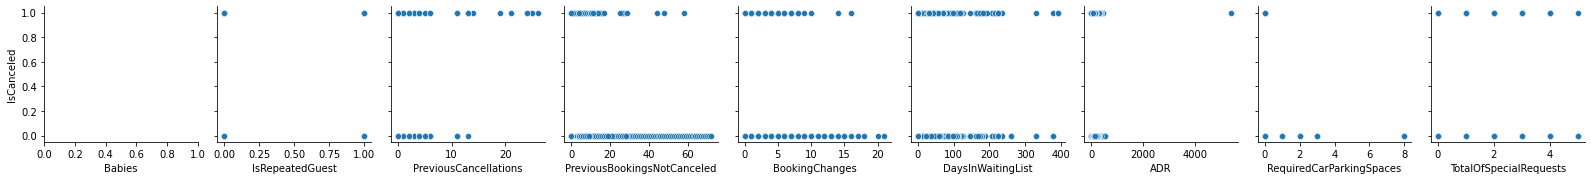

In [ ]:
sns.pairplot(df_combined[quantitative+qual_encoded],y_vars=["IsCanceled"],x_vars=quantitative[9:])

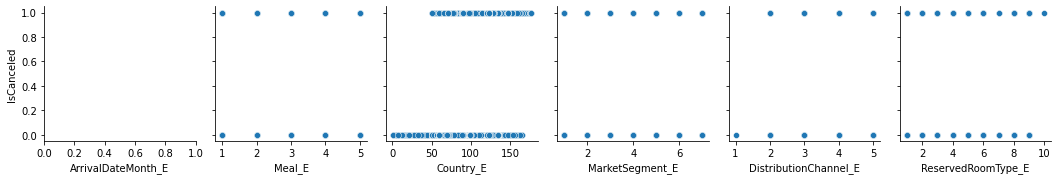

In [ ]:
sns.pairplot(df_combined[quantitative+qual_encoded],y_vars=["IsCanceled"],x_vars=qual_encoded[0:6])

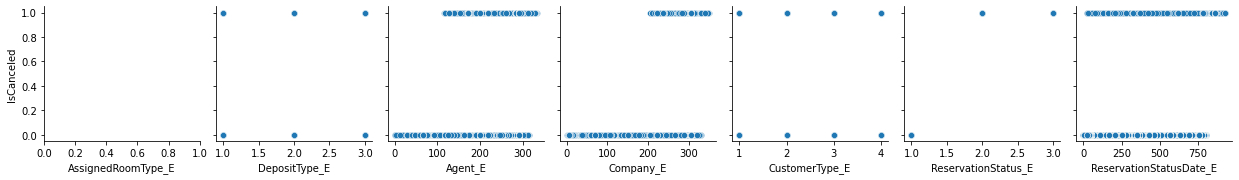

In [ ]:
sns.pairplot(df_combined[quantitative+qual_encoded],y_vars=["IsCanceled"],x_vars=qual_encoded[6:])

## Modelling


In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X = df_combined[quantitative+qual_encoded].drop(leastCorrFeatures+["IsCanceled"],axis=1)
y = df_combined["IsCanceled"]

In [ ]:
X = df_combined[quantitative+qual_encoded].drop(leastCorrFeatures+["IsCanceled"],axis=1)
y = df_combined["IsCanceled"]

Use Random Forest Classifier to check the feature importance

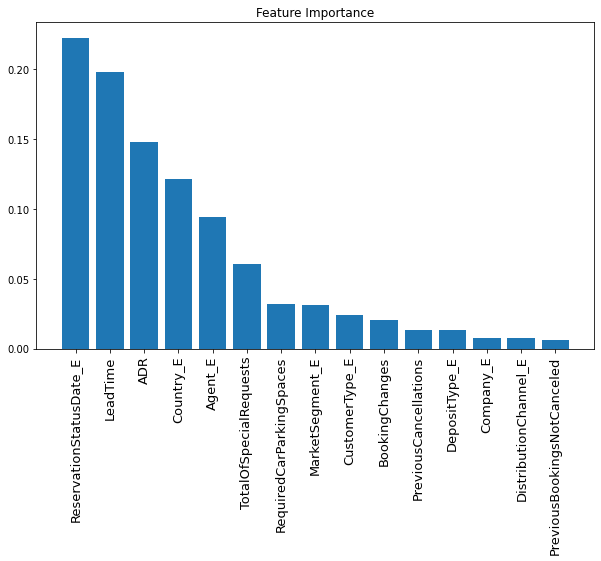

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_combined[quantitative+qual_encoded].drop(leastCorrFeatures+["IsCanceled"],axis=1),df_combined["IsCanceled"],
                                                        test_size=0.30)
# Create decision tree classifer object
clf = RandomForestClassifier(random_state=0, n_jobs=-1)
# Train model
model = clf.fit(X_train,y_train)

# Calculate feature importances
importances = model.feature_importances_
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X_train.columns[i] for i in indices]
importance = [importances[i] for i in indices]
df_sort = pd.DataFrame({
    "names":names,
    "importance":importance
})



# Barplot: Add bars
plt.figure(figsize=(10,6))
plt.bar(range(X_train.shape[1]), importances[indices])
# Add feature names as x-axis labels
plt.xticks(range(X_train.shape[1]), names, rotation=90, fontsize = 13)
# Create plot title
plt.title("Feature Importance")
# Show plot
plt.show()

After removing reservation Status due to its high correlation matrix we see the following are significant for modelling

The code below is significant as:
Important Features are features that will be used to model whereas features will be used to drop the irrelevant feature

In [ ]:
ImportantFeatures = list(df_sort.loc[0:1].names.values)
# get All Feature
features = list(X_train.columns)
# Remove the important features from features
for impFeat in ImportantFeatures:
    features.remove(impFeat)   
# features now store columns to be droped


NameError: ignored

In [ ]:
features
# featuresto be dropped

NameError: ignored

In [ ]:
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB
models = []
models.append(('Rain Forest', RandomForestClassifier()))
models.append(('K nearest Neighbor', KNeighborsClassifier(3)))
models.append(('SVC', SVC()))
models.append(('Naive Bayes', GaussianNB()))
models.append(('ensemble_bagging_D', BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=200, random_state=7)))

NameError: ignored

In [ ]:
scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro','roc_auc']
seed = 7
results = {}
names = []
for name, model in models:
    results[name] = {}
    kfold = model_selection.KFold(n_splits=10, random_state=seed,shuffle=True)
    cv_results = model_selection.cross_validate(model,df_combined[quantitative+qual_encoded].drop(leastCorrFeatures+["IsCanceled"],axis=1),df_combined["IsCanceled"], cv=kfold, scoring=scoring,n_jobs=-1)
    for key,val in cv_results.items():
      results[name][key] = list()
      results[name][key].append(val)
      print(name+ "- "+key+" is Done")

{'fit_time': array([14.54914165, 14.56557536, 14.43038559, 14.46584415, 14.47319746,
       14.46112299, 14.31501317, 14.56609964, 14.59308052, 14.40809941]), 'score_time': array([0.70751357, 0.70678401, 0.69020963, 0.69211483, 0.68582654,
       0.70680118, 0.66314769, 0.70898294, 0.66523218, 0.64318824]), 'test_accuracy': array([0.86795491, 0.87382103, 0.86703474, 0.86381412, 0.87152059,
       0.86588452, 0.85909823, 0.86864504, 0.8694502 , 0.86691971]), 'test_f1_macro': array([0.82923201, 0.83252922, 0.82610229, 0.82496221, 0.83228683,
       0.82699468, 0.81580321, 0.82870719, 0.83218279, 0.82272263]), 'test_precision_macro': array([0.84605313, 0.8488115 , 0.84253129, 0.84024321, 0.84886668,
       0.84383451, 0.83118525, 0.84550556, 0.84550642, 0.84022226]), 'test_recall_macro': array([0.81652895, 0.81987716, 0.81356369, 0.81325738, 0.81959721,
       0.81433633, 0.80400997, 0.81594678, 0.82158837, 0.80945373]), 'test_roc_auc': array([0.92818691, 0.93201479, 0.92297843, 0.9247067

In [ ]:
summary = []
for key, value in results.items():
  for key2,val2 in value.items():

    row = list()
    row.append(key)
    row.append(value[key2][0][0])
    row.append(key2)
    summary.append(row)
  

In [ ]:
metric_df = pd.DataFrame(summary,columns=["algorithm","value","metric"])

In [ ]:
metric_df

,algorithm,value,metric
0,Rain Forest,14.549142,fit_time
1,Rain Forest,0.707514,score_time
2,Rain Forest,0.867955,test_accuracy
3,Rain Forest,0.829232,test_f1_macro
4,Rain Forest,0.846053,test_precision_macro
5,Rain Forest,0.816529,test_recall_macro
6,Rain Forest,0.928187,test_roc_auc
7,K nearest Neighbor,0.448053,fit_time
8,K nearest Neighbor,1.699879,score_time
9,K nearest Neighbor,0.791235,test_accuracy


In [ ]:
metric_df.to_csv('algorithm_info_rev.csv')

In [ ]:
metric_df.pivot_table(index='algorithm', columns='metric').to_csv('algorithm_summary_rev.csv')

In [ ]:
metric_pivot_df =  metric_df[metric_df['metric'].isin(["test_accuracy","test_roc_auc"])]

In [ ]:
metric_pivot_df 

,algorithm,value,metric
2,Rain Forest,0.867955,test_accuracy
6,Rain Forest,0.928187,test_roc_auc
9,K nearest Neighbor,0.791235,test_accuracy
13,K nearest Neighbor,0.797615,test_roc_auc
16,SVC,0.791810,test_accuracy
20,SVC,0.833473,test_roc_auc
23,Naive Bayes,0.553945,test_accuracy
27,Naive Bayes,0.814275,test_roc_auc
30,ensemble_bagging_D,0.864504,test_accuracy
34,ensemble_bagging_D,0.926226,test_roc_auc


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:645: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 1080x720 with 0 Axes>

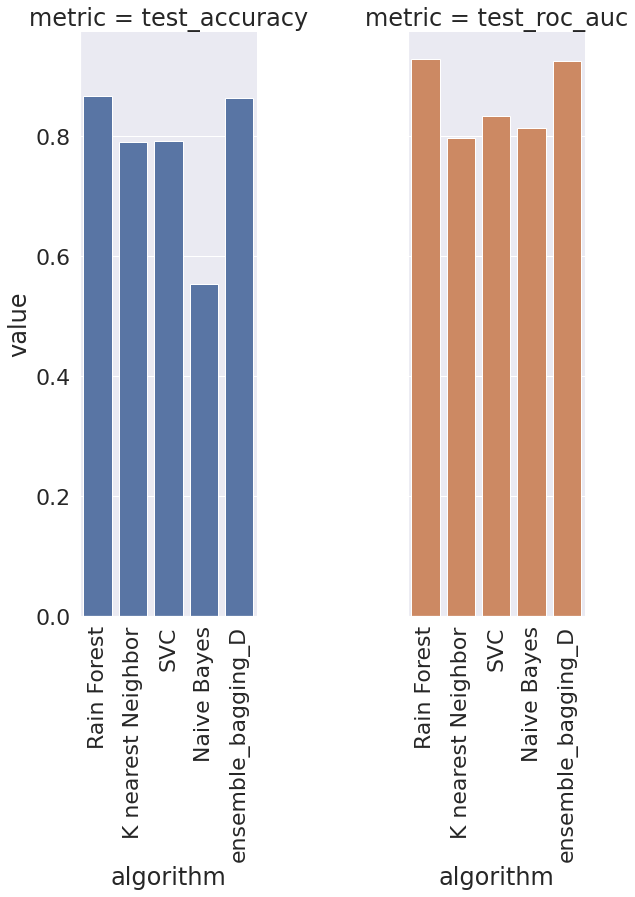

In [ ]:
plt.figure(figsize=(15, 10))
sns.set_theme('paper')
sns.set(font_scale=2)
g = sns.FacetGrid(metric_pivot_df , col="metric", height=10, aspect=.5,hue="metric")
g.map(sns.barplot, "algorithm", "value")
g.set_xticklabels(rotation=90)
g.savefig("output.png")

**Validation**

Using deceptive opinion

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
log-